### Import dependencies

In [1]:
import cv2
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random
from sklearn.metrics import classification_report, confusion_matrix
import glob
import seaborn as sns
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter
import pandas as pd
from PIL import Image

In [2]:
from PIL import Image

def preprocess_lung_image(image_path):
    # Load the image using PIL
    try:
        with Image.open(image_path) as img:
            img = np.array(img.convert('L'))  # Convert to grayscale and then to numpy array
    except Exception as e:
        print(f"Error loading the image: {e}")
        return None, None, None, None, None
    
    # Check if the image has been loaded correctly
    if img is None or img.size == 0:
        print("The image could not be loaded correctly.")
        return None, None, None, None, None
    
    # Adaptive histogram equalization with a smaller grid
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5, 5))
    equalized = clahe.apply(img)
    
    # Find the contour of the chest cavity
    _, binary = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assumed to be the chest cavity)
    if contours:
        main_contour = max(contours, key=cv2.contourArea)
    else:
        print("No contours found in the image.")
        return img, equalized, None, None, None
    
    # Create a mask with the contour
    mask = np.zeros_like(equalized)
    cv2.drawContours(mask, [main_contour], -1, (255), thickness=cv2.FILLED)
    
    # Apply the mask to the equalized image
    masked_image = cv2.bitwise_and(equalized, equalized, mask=mask)
    
    # Create a color image with three channels (RGB) to draw the contour in red
    contour_image = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2BGR)
    
    # Draw the contour in red (RGB: 255, 0, 0)
    for point in main_contour:
        contour_image[point[0][1], point[0][0]] = [255, 0, 0]
    
    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(main_contour)
    
    # Crop the image
    cropped = masked_image[y:y+h, x:x+w]
    
    # Make the image square
    size = max(w, h)
    square = np.zeros((size, size), dtype=np.uint8)
    
    # Center the cropped image in the square
    start_x = (size - w) // 2
    start_y = (size - h) // 2
    square[start_y:start_y+h, start_x:start_x+w] = cropped
    
    # Resize to 250x250
    resized = cv2.resize(square, (250, 250))
    
    return img, equalized, binary, mask, cropped, square, resized

class LungCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = {"adenocarcinoma": 0, "large.cell.carcinoma": 1, "normal": 2, "squamous.cell.carcinoma": 3}
        self.filepaths = []
        self.targets = []
        
        for label in self.labels.keys():
            paths = glob.glob(f"{root_dir}/{label}/*.png")
            self.filepaths.extend(paths)
            self.targets.extend([self.labels[label]] * len(paths))
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, index):
        image_path = self.filepaths[index]
        img, equalized, binary, mask, cropped, square, resized = preprocess_lung_image(image_path)
        img = np.stack((resized, resized, resized), axis=-1)  # Create a 3-channel image
        
        if self.transform:
            img = self.transform(img)
        
        label = self.targets[index]
        return img, label
    
    def show_images(self, num_images=6, rows=2):
        cols = num_images // rows
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
        indices = random.sample(range(len(self)), num_images)
        
        for ax, index in zip(axes.flatten(), indices):
            img_path = self.filepaths[index]
            img, equalized, binary, mask, cropped, square, resized = preprocess_lung_image(img_path)
            label = self.targets[index]
            label_name = list(self.labels.keys())[list(self.labels.values()).index(label)]
            ax.imshow(resized, cmap='gray')
            ax.axis('off')
            ax.set_title(label_name)
        
        plt.tight_layout()
        plt.show()

# Define transforms (if any)
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [3]:
# Create dataset instances
train_dataset = LungCancerDataset(root_dir='./data/train', transform=data_transforms)
valid_dataset = LungCancerDataset(root_dir='./data/valid', transform=data_transforms)

# Use DataLoader to create batches
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

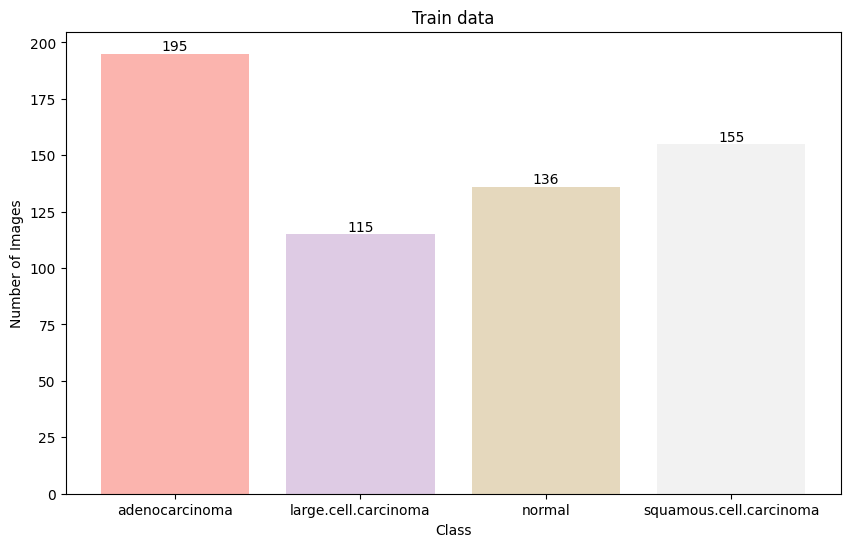

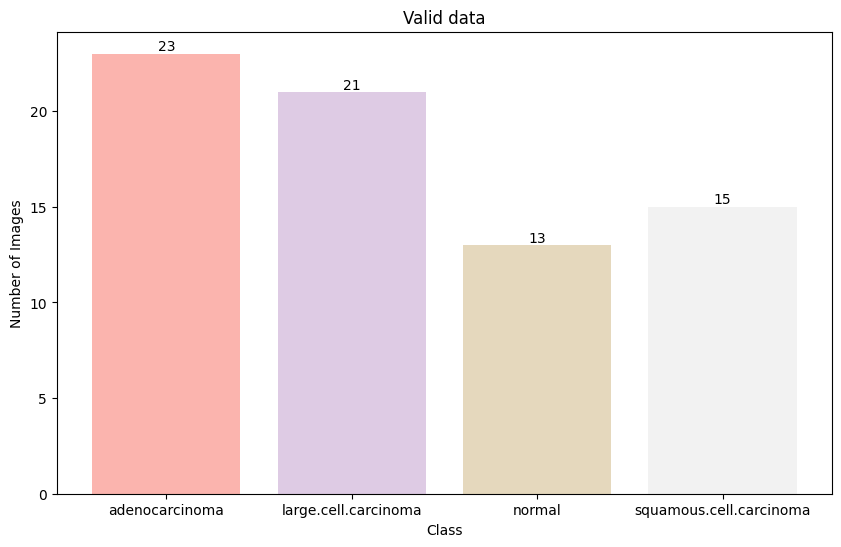

In [4]:
def plot_nimages(dataset, count, name):
    class_names = list(dataset.labels.keys())
    counts = [count[dataset.labels[class_name]] for class_name in class_names]

    colors = plt.cm.Pastel1(np.linspace(0, 1, len(class_names)))

    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(class_names):
        plt.bar(class_name, counts[i], color=colors[i])

    plt.title(name)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')

    for index, value in enumerate(counts):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.show()
    
# Count the number of images per class
train_count = Counter(train_dataset.targets)
valid_count = Counter(valid_dataset.targets)
    
# Plot the number of images per class
plot_nimages(train_dataset, train_count, name='Train data')
plot_nimages(valid_dataset, valid_count, name='Valid data')

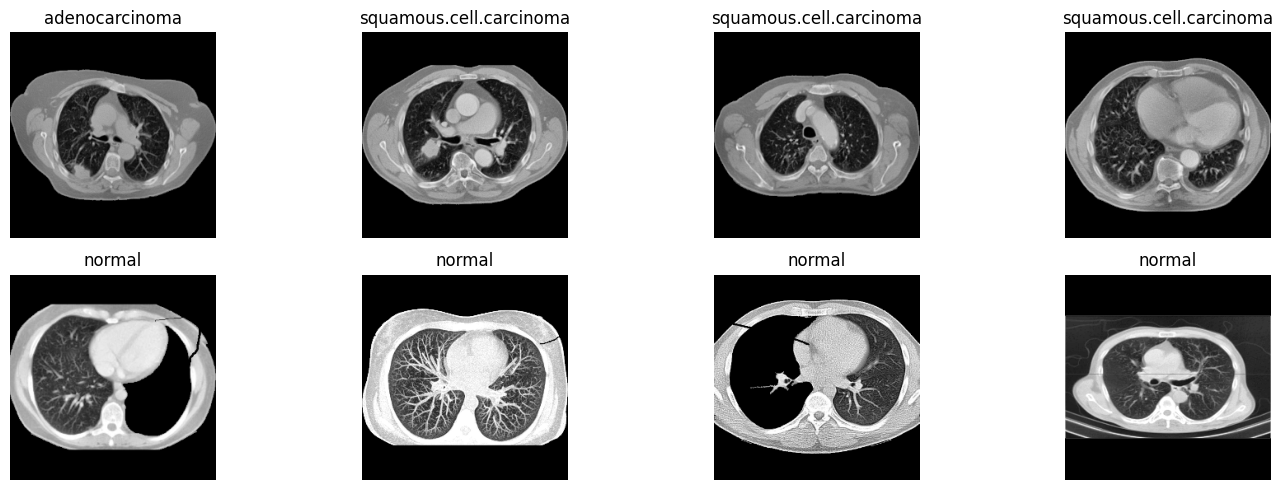

In [5]:
train_dataset.show_images(num_images=8, rows=2)

In [6]:
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes=4):
        super(ModifiedResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(num_ftrs, num_classes)
        )
        self.batch_norm = nn.BatchNorm1d(num_ftrs)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.batch_norm(x)
        x = self.model.fc(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedResNet50().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-7)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

def train_model(dataloader, model, criterion, optimizer, num_epochs):
    train_loss_history = []
    valid_loss_history = []
    valid_acc_history = []
    
    best_model_wts = None
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        
        for i, (inputs, labels) in enumerate(dataloader['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader['train'].dataset)
        train_loss_history.append(epoch_loss)
        
        val_loss, val_acc = validate_model(dataloader['valid'], model, device, criterion)
        valid_loss_history.append(val_loss)
        valid_acc_history.append(val_acc)
        
        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
        scheduler.step(val_loss)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()
    
    print(f'Best Validation Accuracy: {best_acc}')
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_model.pth')
    
    return train_loss_history, valid_loss_history, valid_acc_history

/home/drtey/dev/chest-CT-Scan/ctscan/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/drtey/dev/chest-CT-Scan/ctscan/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/drtey/dev/chest-CT-Scan/ctscan/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [8]:
def validate_model(dataloader, model, device, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(dataloader.dataset)
    accuracy = correct / total
    
    return loss, accuracy

Epoch 0/31, Train Loss: 0.7083183721873209, Validation Loss: 1.02857420179579, Validation Accuracy: 0.5
Epoch 1/31, Train Loss: 0.06558760916333825, Validation Loss: 0.5445596906873915, Validation Accuracy: 0.8333333333333334
Epoch 2/31, Train Loss: 0.02508007367443721, Validation Loss: 0.38538617226812577, Validation Accuracy: 0.8611111111111112
Epoch 3/31, Train Loss: 0.010622009970464693, Validation Loss: 0.4139491187201606, Validation Accuracy: 0.8611111111111112
Epoch 4/31, Train Loss: 0.0058195767831212275, Validation Loss: 0.37161914507548016, Validation Accuracy: 0.8611111111111112
Epoch 5/31, Train Loss: 0.004363249257492047, Validation Loss: 0.28655196643537945, Validation Accuracy: 0.9027777777777778
Epoch 6/31, Train Loss: 0.006298756471446896, Validation Loss: 0.24511973575378457, Validation Accuracy: 0.9027777777777778
Epoch 7/31, Train Loss: 0.006288742803086754, Validation Loss: 0.21075770672824648, Validation Accuracy: 0.9305555555555556
Epoch 8/31, Train Loss: 0.00571

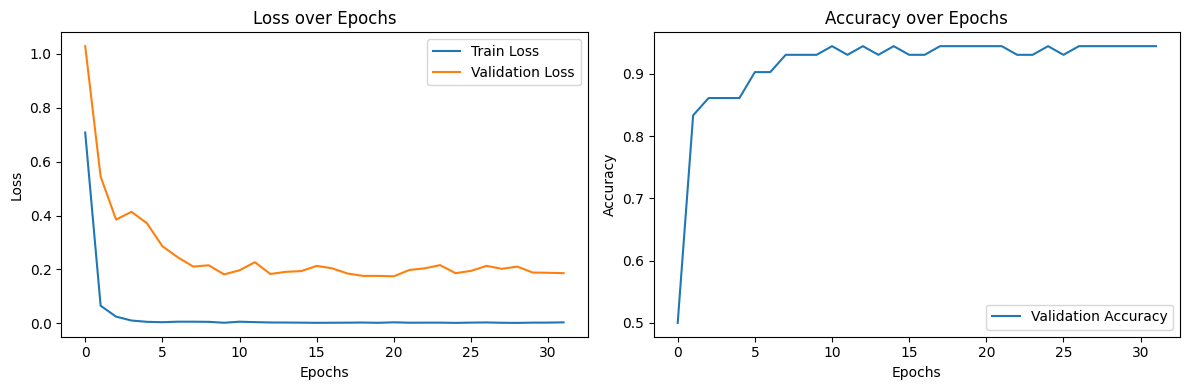

Accuracy of the model on the test images: 92.6984126984127%


In [9]:
def plot_metrics(train_loss, valid_loss, valid_acc):
    epochs = range(len(train_loss))
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    
    plt.tight_layout()
    plt.show()

dataloader = {'train': train_dataloader, 'valid': valid_dataloader}

num_epochs = 32
train_loss, valid_loss, valid_acc = train_model(dataloader, model, criterion, optimizer, num_epochs)

plot_metrics(train_loss, valid_loss, valid_acc)

test_dataset = LungCancerDataset(root_dir='./data/test', transform=data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def test_model(test_dataloader, model, device):
    model.eval()
    correct = 0
    total = 0
    test_predictions = []
    test_labels = []
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_predictions.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    print(f'Accuracy of the model on the test images: {100 * accuracy}%')
    return test_labels, test_predictions

test_labels, test_predictions = test_model(test_dataloader, model, device)

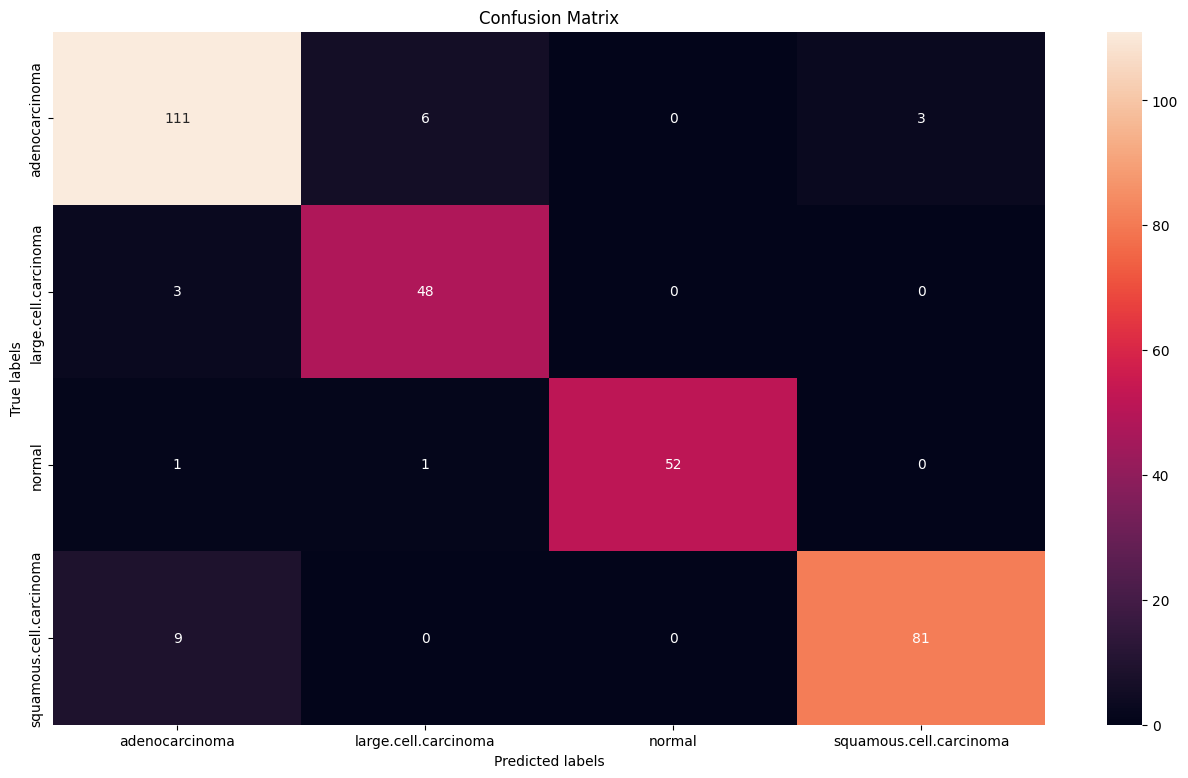

In [10]:
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(16, 9))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'])
ax.yaxis.set_ticklabels(['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'])
plt.show()

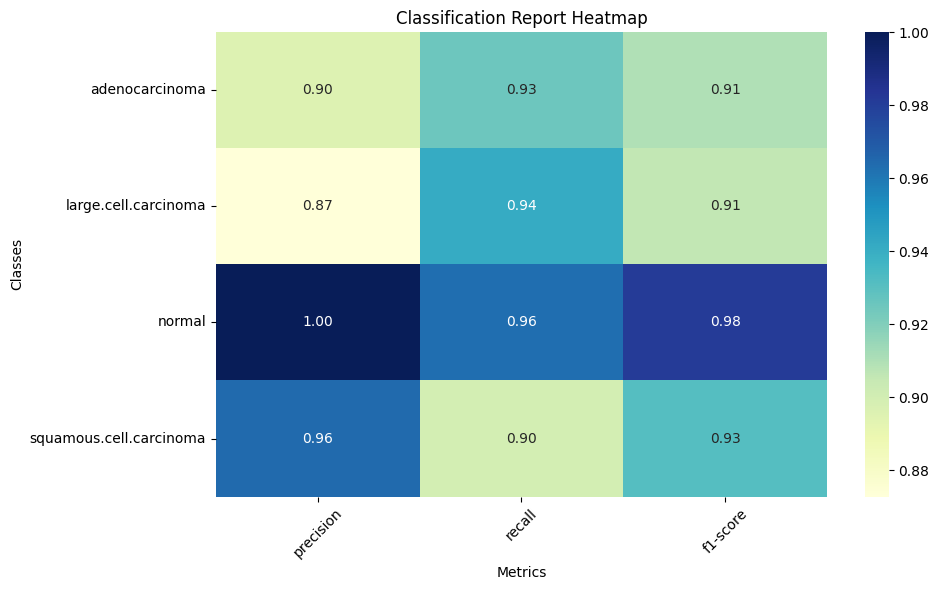

In [11]:
report = classification_report(test_labels, test_predictions, target_names=['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'], output_dict=True)

df = pd.DataFrame(report).T
df = df.drop(columns=['support'])  

plt.figure(figsize=(10, 6))
sns.heatmap(df.iloc[:-3, :], annot=True, cmap='YlGnBu', cbar=True, fmt='.2f')

plt.title('Classification Report Heatmap')
plt.ylabel('Classes')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()